In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

#register matplotlib converters which have been overwritten by pandas
register_matplotlib_converters()

# import & manipulate IÖW data

In [6]:
folder_ioew ='ioew_data_etc/aggregation/raw'

In [7]:
input_files = []
path = os.getcwd() + '/' + folder_ioew
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            input_files.append(file)
input_files.sort()

# import
df_dsm = {}
for file in input_files:
    data = pd.read_csv(folder_ioew +'/'+file, sep = ";", decimal=',', encoding='utf-8')
    df_dsm.update({file:data})

In [8]:
vergleich = pd.DataFrame()
for key, df in df_dsm.items():
    vergleich = vergleich.append(df.sum().rename(key))
vergleich.iloc[:,:-1]

,Grundlast,Grundlast_und_schwer_Flexibilisierbar,Standardlast,Standardlast_und_leicht_Flexibilisierbar,Standardlast_und_maximal_Flexibilisierbar
Dessau_Test_a_1HH_3Personen.csv,596.990668,631.212817,1000.0,2035.874420,2233.751062
Dessau_Test_b_10HH.csv,662.490943,693.076855,1000.0,1586.106729,1722.835184
Dessau_Test_c_50HH.csv,668.352186,700.504882,1000.0,1570.154289,1713.588541
Dessau_Test_d_100HH.csv,671.680911,703.817901,1000.0,1560.612566,1704.427321


In [10]:
df_power = pd.read_csv('./ioew_data_etc/ABW_15091010_timeseries_wind_pv_2013.csv',
                       sep = ",", decimal='.', encoding='utf-8')
print(df_power.shape)
start = df_power.timestamp.iloc[0]
end = df_power.timestamp.iloc[-1]
df_power['timestamp'] = pd.date_range(start=start, end=end, freq='H')
df_power.set_index('timestamp', inplace=True)
df_power.index = pd.to_datetime(df_power.index).tz_convert('Europe/Berlin')

# normieren auf 1000 kWh/J
df_power = df_power/df_power.sum().sum()*1000


df_output = {}
for key in df_dsm.keys():
    df_output.update({key:df_power.copy()})

(8760, 3)


In [11]:
for key ,df in df_dsm.items():
    df.drop(columns=['Stunde','Grundlast','Standardlast_und_maximal_Flexibilisierbar'], inplace=True)
    df['timestamp'] = df_power.index
    df.set_index('timestamp', inplace=True, drop=True)
    
    
    df_output[key]['cap_do'] = (df['Standardlast'] - df['Grundlast_und_schwer_Flexibilisierbar'])

    df_output[key]['cap_up'] =  (df['Standardlast_und_leicht_Flexibilisierbar']-df['Standardlast'])
    df_output[key]['demand_el'] = df['Standardlast']

    

In [16]:
vergleich  = pd.DataFrame()
for key, df in df_output.items():
    vergleich = vergleich.append(df.sum().rename(key))
vergleich.style.bar(axis=0 ,color='goldenrod', subset=['cap_do','cap_up'])

,cap_do,cap_up,demand_el,pv,wind
Dessau_Test_a_1HH_3Personen.csv,368.787,1035.87,1000,194.154,805.846
Dessau_Test_b_10HH.csv,306.923,586.107,1000,194.154,805.846
Dessau_Test_c_50HH.csv,299.495,570.154,1000,194.154,805.846
Dessau_Test_d_100HH.csv,296.182,560.613,1000,194.154,805.846


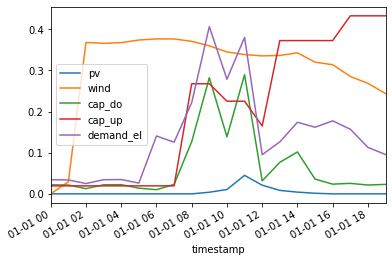

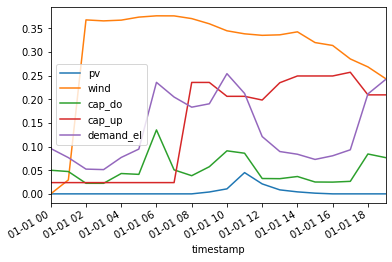

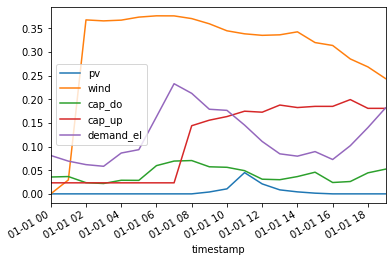

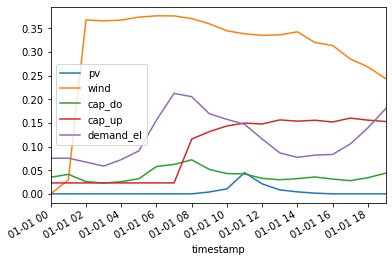

In [14]:
for df in df_output.values():
    df.head(20).plot()

# -> use DSM Model

--------

# import DSM-Model-ouput

In [17]:
folder='dsm_data_dumps/aggregation'
#folder='dsm_data_dumps/vgl_delay_12h-interval_24h' # 12 h delay time  vs. 24 h interval / whole march
#folder='dsm_data_dumps/guidos_day' # 12 h delay  vs. 224 h interval / 1 day 


###### model presets costs:
    - shortage :200
    - coal     : 10
    - dsm      :  5
    - excess   :  1
    - wind     :  0
    - pv       :  0   

#### import data

In [21]:
input_files = []
path = os.getcwd() + '/' + folder
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            input_files.append(file)
input_files.sort()

# import
df_data = {}
for file in input_files:
    data = pd.read_csv(folder+'/'+file, sep = ";", decimal=',', encoding='utf-8', index_col=0)
    df_data.update({file:data})

#### DATA

In [22]:
tz = 'Europe/Berlin'

# update timestamp
for df in df_data.values():
    df.index = pd.to_datetime(df.index).tz_convert(tz)
pd.DataFrame(df_data[list(df_data)[0]].columns, columns=['header']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
header,coal1,wind,pv,excess,shortage,demand_dsm,dsm_do,dsm_up,dsm_tot,dsm_acum,demand_el,cap_up,cap_do


In [25]:
display(list(df_data.keys()))

['Dessau_Test_a_1HH_3Personen_delay_12h_1M.csv',
 'Dessau_Test_a_1HH_3Personen_interval_24h_1M.csv',
 'Dessau_Test_b_10HH_delay_12h_1M.csv',
 'Dessau_Test_b_10HH_interval_24h_1M.csv',
 'Dessau_Test_c_50HH_delay_12h_1M.csv',
 'Dessau_Test_c_50HH_interval_24h_1M.csv',
 'Dessau_Test_d_100HH_delay_12h_1M.csv',
 'Dessau_Test_d_100HH_interval_24h_1M.csv']

# Plots
### settings

In [27]:
style =  ['-', '--', '-.', ':']
color=['teal','coral','olive','goldenrod', 'orchid', 'silver', 'seagreen', 'slateblue']
drawstyle= {'scientific':{'step':'pre','drawstyle':'steps-pre'},'normal':{'step':None,'drawstyle':None }}

In [38]:
timesteps = 27
string='delay'

start = df.index[23]

ds = drawstyle['normal']

figure_size = (15,6)

steps =pd.date_range(start, periods=timesteps, freq='H', tz=tz)
end = steps[-1]

# Info
print('Files visualized')
display([keys for keys in df_data.keys() if string in keys])
start

Files visualized


['Dessau_Test_a_1HH_3Personen_delay_12h_1M.csv',
 'Dessau_Test_b_10HH_delay_12h_1M.csv',
 'Dessau_Test_c_50HH_delay_12h_1M.csv',
 'Dessau_Test_d_100HH_delay_12h_1M.csv']

Timestamp('2013-03-01 23:00:00+0100', tz='Europe/Berlin')

In [39]:
# show annual total 
dsm = pd.DataFrame()

for index, df in df_data.items():
    if string in index:
        dsm[index[:-4]]  =df.abs().sum().round()
        dsm.loc['gen_total', index[:-4],] = df[['wind', 'pv', 'coal1']].sum().sum().round()
        dsm.loc['gen_EE', index[:-4]] = df[['wind', 'pv']].sum().sum().round()
#dsm#.iloc[:9]
dsm.loc[['demand_el','dsm_tot','excess',
         'cap_up', 'cap_do',
         'gen_total','gen_EE',
         'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='silver')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
Dessau_Test_a_1HH_3Personen_delay_12h_1M,91,18,43,109,34,134,111,96,15,23
Dessau_Test_b_10HH_delay_12h_1M,92,14,42,59,27,134,111,96,15,22
Dessau_Test_c_50HH_delay_12h_1M,89,13,43,57,27,132,111,96,15,21
Dessau_Test_d_100HH_delay_12h_1M,88,13,44,53,26,132,111,96,15,21


# resulting DSM

5
['dsm_tot', 'dsm_tot', 'dsm_tot', 'dsm_tot', 'zero-line']


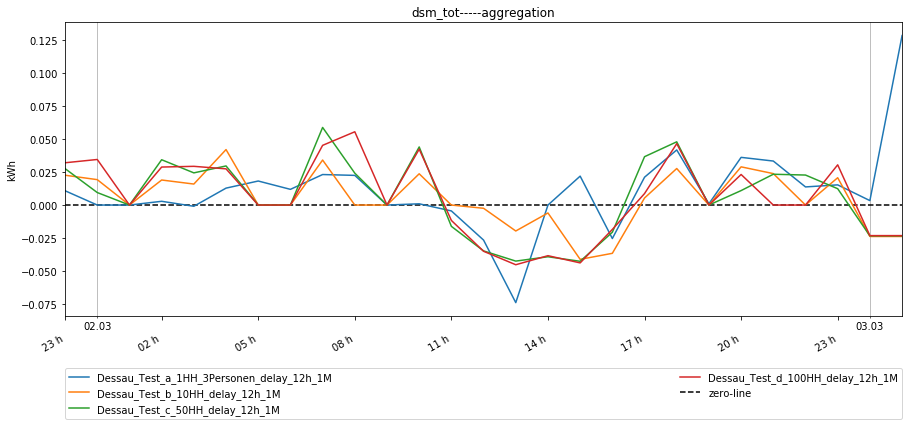

In [40]:
column = 'dsm_tot'

fig_dsm,ax = plt.subplots(figsize=figure_size)
ax.set_title("{}-----{}".format(column,folder[15:]))


ax.hlines(y=0,xmin=start, xmax=end, linestyle='--' ,label='zero-line')

keys=[]
for i, (key, df) in enumerate(df_data.items()):
    if string in key:
        ax = df.loc[steps,column].plot(ax=ax, drawstyle=ds['drawstyle'])#, color=color[i])
        keys.append(key)
    
ax.set_ylabel('kWh')
ax.set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
ax.xaxis.grid(True, which="minor")
ax.xaxis.grid(False, which="major")

handles, labels = ax.get_legend_handles_labels()
print(len(labels))
print(labels)
labels = ['{}'.format(keys[:-4])for keys in keys]
labels.append('zero-line')


ax.legend(labels, bbox_to_anchor=(0., -.35, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
ax_dsm = ax
plt.show()

### DSM accumulated

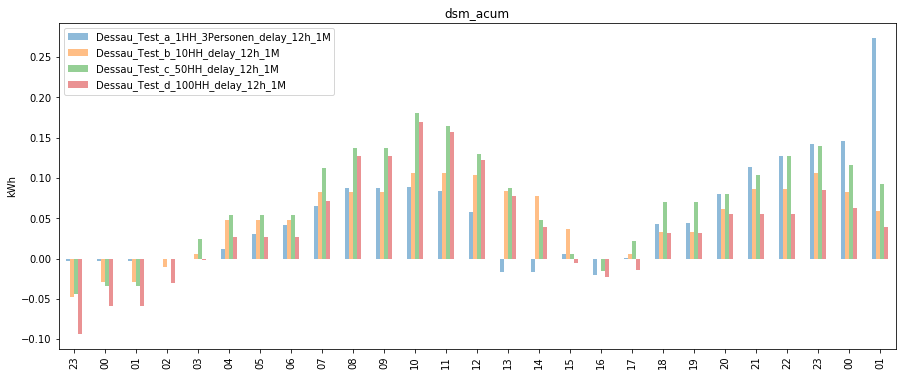

In [41]:
column = 'dsm_acum'


fig_acum,ax = plt.subplots(figsize=figure_size)
ax.set_title(column)


keys=[]
df_acum=pd.DataFrame()
for i, (key, df) in enumerate(df_data.items()):
    if string in key:
        df_acum = df_acum.join(df.loc[steps,column],how='outer', rsuffix=str(i))
        keys.append(key)
        
df_acum.loc[steps].plot(ax=ax,kind='bar',alpha=0.5)#, color=color)
ax.set_ylabel('kWh')

handles, _ = ax.get_legend_handles_labels()

labels = ['{}'.format(keys[:-4])for keys in keys]
ax.set_xticklabels(steps.strftime("%H"))


plt.legend(labels)
ax_acum = ax
plt.show()

## demand & dsm

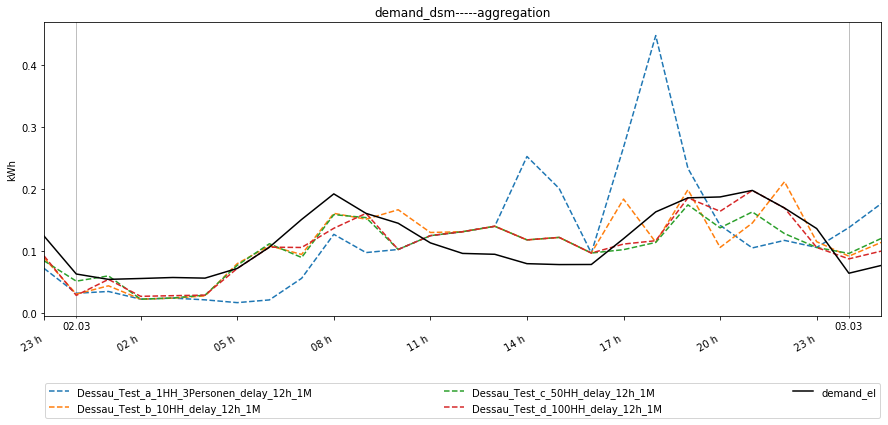

In [42]:
column = 'demand_dsm'

fig_demand,ax = plt.subplots(figsize=figure_size)
ax.set_title("{}-----{}".format(column,folder[15:]))



# plot demand
#ax = df_data[list(df_data)[0]].loc[steps,'demand_el'].abs().plot(color='black', drawstyle=ds['drawstyle'])

# plot resulting dsm
keys=[]
for i, (key, df) in enumerate(df_data.items()):
    if string in key:
        keys.append(key)
        ax = df.loc[steps,column].plot(ax=ax, style='--', drawstyle=ds['drawstyle'])#, color=color[i] )

df.loc[steps,'demand_el'].plot(ax=ax, color='black', drawstyle=ds['drawstyle'])
        
ax.set_ylabel('kWh')
ax.set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
ax.xaxis.grid(True, which="minor")
ax.xaxis.grid(False, which="major")


handles, _ = ax.get_legend_handles_labels() 
labels = ['{}'.format(keys[:-4])for keys in keys]

labels.append('demand_el')
ax.legend(labels, bbox_to_anchor=(0., -.35, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.1)
ax_demand = ax
plt.show()

### Capacity

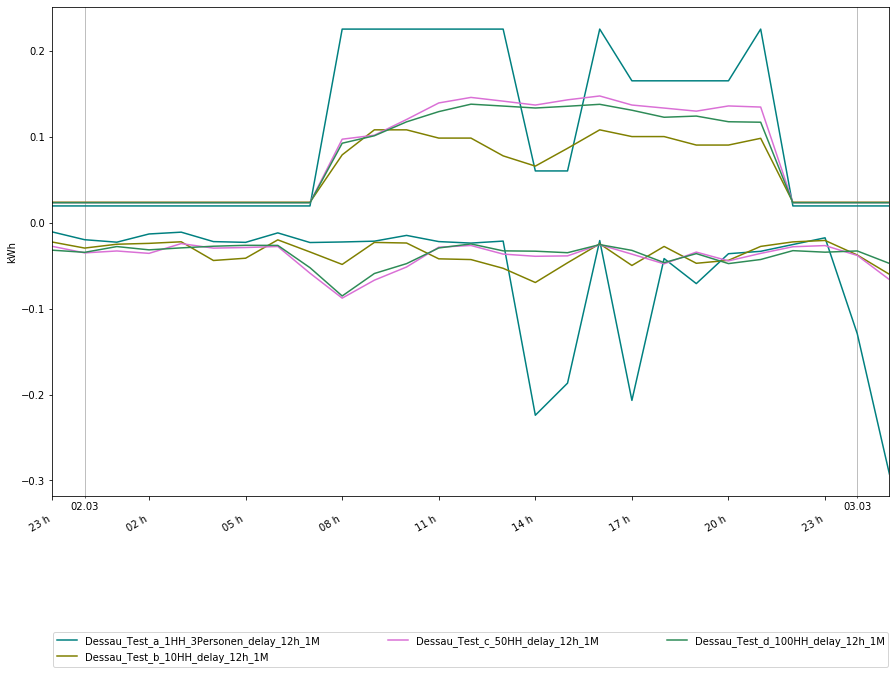

In [43]:
column = ['cap_do','cap_up']

fig_cap, ax = plt.subplots(figsize=(15,10))

#ax.set_title("{}-----{}".format(column,folder[15:]))

keys=[]
for i, (key, df) in enumerate(df_data.items()):
    if string in key:
        keys.append(key)
        (df*-1).loc[steps,'cap_do'].plot(ax=ax, drawstyle=ds['drawstyle'],color=color[i])#, style=style[i])
        
        df.loc[steps,'cap_up'].plot(ax=ax, drawstyle=ds['drawstyle'], color=color[i])#, style=style[i])

        
ax.set_ylabel('kWh')
ax.set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
ax.xaxis.grid(True, which="minor")
ax.xaxis.grid(False, which="major")


handles, _ = ax.get_legend_handles_labels()
handles = handles[::2]
labels = ['{}'.format(keys[:-4])for keys in keys]

ax.legend(handles, labels, bbox_to_anchor=(0., -.35, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.1)

ax_cap = ax
plt.show()


# Gen

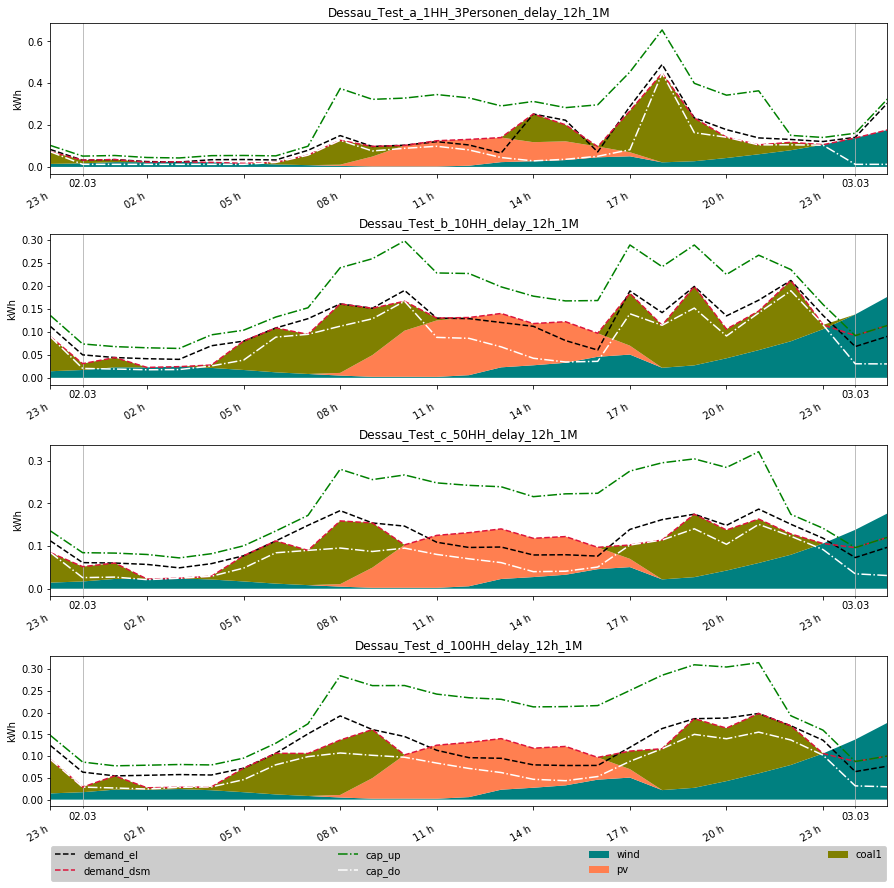

In [44]:
column = ['wind', 'pv', 'coal1']
plots = len([s for s in df_data.keys() if string in s])
fig_all, ax = plt.subplots(max(plots,2),1,figsize=(15,plots*4))

i=0
keys=[]
for _, (key, df) in enumerate(df_data.items()):
    if string in key:
        keys.append(key)
    
        ax[i].set_title(key[:-4])
        
        # area plot generation
        upper = 0
        lower = 0
        for gen, col in enumerate(df[column]):
            upper += df.copy().loc[steps, col]
            upper.name = col
            ax[i].fill_between(steps, lower, upper, step=ds['step'], facecolor=color[gen], label=col)
            lower = upper.copy()

        # plot demand
        ax[i] = df.loc[steps,'demand_el'].plot(ax=ax[i], drawstyle=ds['drawstyle'], style='--', color='black')
        ax[i] = df.loc[steps,'demand_dsm'].plot(ax=ax[i], drawstyle=ds['drawstyle'], style='--', color='crimson')
        
        # calc & plot upper capacity
        cap_up = df.loc[steps,'demand_el'] + df.loc[steps,'cap_up']
        cap_up.name='cap_up'
        ax[i] = cap_up.plot(ax=ax[i], drawstyle=ds['drawstyle'], style='-.', color='green')

        # calc 
        cap_down = df.loc[steps,'demand_el'] - df.loc[steps,'cap_do']
        cap_down.name='cap_do'
        ax[i] = cap_down.plot(ax=ax[i], drawstyle=ds['drawstyle'], style='-.', color='white')

        ax[i].set_ylabel('kWh')
        ax[i].set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
        ax[i].xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
        ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
        ax[i].xaxis.grid(True, which="minor")
        ax[i].xaxis.grid(False, which="major")
        i+=1

handles, labels = ax[i-1].get_legend_handles_labels()
ax[i-1].legend(labels,
             bbox_to_anchor=(0., -.5, 1., .102),
             loc=3, ncol=4,
             mode="expand",
             borderaxespad=0.1,
             facecolor='silver')
fig_all.subplots_adjust(hspace = 0.4)
plt.show()

# all plots